In [4]:
import pickle
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

In [5]:
# Main source for the training data
DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
# Local file
DATA_FILE = 'data/OxCGRT_latest.csv'

In [6]:
import os
import urllib.request
if not os.path.exists('data'):
    os.mkdir('data')
urllib.request.urlretrieve(DATA_URL, DATA_FILE)

('data/OxCGRT_latest.csv', <http.client.HTTPMessage at 0x7f177cc88d00>)

In [7]:
# Load historical data from local file
df = pd.read_csv(DATA_FILE, 
                 parse_dates=['Date'],
                 encoding="ISO-8859-1",
                 dtype={"RegionName": str,
                        "RegionCode": str},
                 error_bad_lines=False)

In [8]:
df.columns

Index(['CountryName', 'CountryCode', 'RegionName', 'RegionCode',
       'Jurisdiction', 'Date', 'C1_School closing', 'C1_Flag',
       'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events', 'C3_Flag',
       'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport',
       'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag',
       'C7_Restrictions on internal movement', 'C7_Flag',
       'C8_International travel controls', 'E1_Income support', 'E1_Flag',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'H6_Facial Coverings', 'H6_Flag', 'M1_Wildcard', 'ConfirmedCases',
       'ConfirmedDeaths', 'StringencyIndex', 'StringencyIndexForDisplay',
       'StringencyLegacyIndex', 'StringencyLegacyIndexForDisplay',
       'GovernmentResponseIndex', 'Gove

In [9]:
# Validate on month of august
df = df[df.Date >= np.datetime64("2020-08-01")]
df = df[df.Date <= np.datetime64("2020-08-31")]

In [10]:
# Add RegionID column that combines CountryName and RegionName for easier manipulation of data
df['GeoID'] = df['CountryName'] + '__' + df['RegionName'].astype(str)

In [11]:
# Add new cases column
df['NewCases'] = df.groupby('GeoID').ConfirmedCases.diff().fillna(0)

In [12]:
# Keep only columns of interest
id_cols = ['CountryName',
           'RegionName',
           'GeoID',
           'Date']
cases_col = ['NewCases']
df = df[id_cols + cases_col]
df['UID'] = df['GeoID'] + df['Date'].astype(str)
df

,CountryName,RegionName,GeoID,Date,NewCases,UID
213,Aruba,NaN,Aruba__nan,2020-08-01,0.0,Aruba__nan2020-08-01
214,Aruba,NaN,Aruba__nan,2020-08-02,0.0,Aruba__nan2020-08-02
215,Aruba,NaN,Aruba__nan,2020-08-03,1.0,Aruba__nan2020-08-03
216,Aruba,NaN,Aruba__nan,2020-08-04,2.0,Aruba__nan2020-08-04
217,Aruba,NaN,Aruba__nan,2020-08-05,8.0,Aruba__nan2020-08-05
...,...,...,...,...,...,...
87095,Zimbabwe,NaN,Zimbabwe__nan,2020-08-27,55.0,Zimbabwe__nan2020-08-27
87096,Zimbabwe,NaN,Zimbabwe__nan,2020-08-28,41.0,Zimbabwe__nan2020-08-28
87097,Zimbabwe,NaN,Zimbabwe__nan,2020-08-29,96.0,Zimbabwe__nan2020-08-29
87098,Zimbabwe,NaN,Zimbabwe__nan,2020-08-30,18.0,Zimbabwe__nan2020-08-30


In [13]:
df

,CountryName,RegionName,GeoID,Date,NewCases,UID
213,Aruba,NaN,Aruba__nan,2020-08-01,0.0,Aruba__nan2020-08-01
214,Aruba,NaN,Aruba__nan,2020-08-02,0.0,Aruba__nan2020-08-02
215,Aruba,NaN,Aruba__nan,2020-08-03,1.0,Aruba__nan2020-08-03
216,Aruba,NaN,Aruba__nan,2020-08-04,2.0,Aruba__nan2020-08-04
217,Aruba,NaN,Aruba__nan,2020-08-05,8.0,Aruba__nan2020-08-05
...,...,...,...,...,...,...
87095,Zimbabwe,NaN,Zimbabwe__nan,2020-08-27,55.0,Zimbabwe__nan2020-08-27
87096,Zimbabwe,NaN,Zimbabwe__nan,2020-08-28,41.0,Zimbabwe__nan2020-08-28
87097,Zimbabwe,NaN,Zimbabwe__nan,2020-08-29,96.0,Zimbabwe__nan2020-08-29
87098,Zimbabwe,NaN,Zimbabwe__nan,2020-08-30,18.0,Zimbabwe__nan2020-08-30


In [14]:
prediction = pd.read_csv("predictions/2020-08-01_2020-08-31.csv", 
                 parse_dates=['Date'],
                 encoding="ISO-8859-1",
                 error_bad_lines=False)
prediction['GeoID'] = prediction['CountryName'] + '__' + prediction['RegionName'].astype(str)
prediction['UID'] = prediction['GeoID'] + prediction['Date'].astype(str)
prediction

,CountryName,RegionName,Date,PredictedDailyNewCases,GeoID,UID
0,Aruba,NaN,2020-08-01,8.971074,Aruba__nan,Aruba__nan2020-08-01
1,Aruba,NaN,2020-08-02,8.938848,Aruba__nan,Aruba__nan2020-08-02
2,Aruba,NaN,2020-08-03,9.680412,Aruba__nan,Aruba__nan2020-08-03
3,Aruba,NaN,2020-08-04,12.139686,Aruba__nan,Aruba__nan2020-08-04
4,Aruba,NaN,2020-08-05,9.611990,Aruba__nan,Aruba__nan2020-08-05
...,...,...,...,...,...,...
7280,Zimbabwe,NaN,2020-08-27,45.087841,Zimbabwe__nan,Zimbabwe__nan2020-08-27
7281,Zimbabwe,NaN,2020-08-28,41.698625,Zimbabwe__nan,Zimbabwe__nan2020-08-28
7282,Zimbabwe,NaN,2020-08-29,38.644612,Zimbabwe__nan,Zimbabwe__nan2020-08-29
7283,Zimbabwe,NaN,2020-08-30,36.841428,Zimbabwe__nan,Zimbabwe__nan2020-08-30


In [15]:
ids = sorted(list(set(prediction.UID)))
df = df[df.UID.isin(ids)]

In [16]:
# Helpful function to compute mae
def mae(pred, true):
    return np.mean(np.abs(pred - true))

In [17]:
pred = prediction["PredictedDailyNewCases"]
true = df["NewCases"]
print(pred, true)

0        8.971074
1        8.938848
2        9.680412
3       12.139686
4        9.611990
          ...    
7280    45.087841
7281    41.698625
7282    38.644612
7283    36.841428
7284    35.061515
Name: PredictedDailyNewCases, Length: 7285, dtype: float64 213       0.0
214       0.0
215       1.0
216       2.0
217       8.0
         ... 
87095    55.0
87096    41.0
87097    96.0
87098    18.0
87099     6.0
Name: NewCases, Length: 7285, dtype: float64


In [18]:
error = mae(pred, true)
print(error)

2947.089970666108


In [19]:
df['CountryName'].unique()

array(['Aruba', 'Afghanistan', 'Angola', 'Albania', 'Andorra',
       'United Arab Emirates', 'Argentina', 'Australia', 'Austria',
       'Azerbaijan', 'Burundi', 'Belgium', 'Benin', 'Burkina Faso',
       'Bangladesh', 'Bulgaria', 'Bahrain', 'Bosnia and Herzegovina',
       'Belarus', 'Belize', 'Bermuda', 'Bolivia', 'Brazil', 'Barbados',
       'Brunei', 'Bhutan', 'Botswana', 'Central African Republic',
       'Canada', 'Switzerland', 'Chile', 'China', "Cote d'Ivoire",
       'Cameroon', 'Democratic Republic of Congo', 'Congo', 'Colombia',
       'Comoros', 'Cape Verde', 'Costa Rica', 'Cuba', 'Cyprus',
       'Czech Republic', 'Germany', 'Djibouti', 'Dominica', 'Denmark',
       'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt', 'Eritrea',
       'Spain', 'Estonia', 'Ethiopia', 'Finland', 'Fiji', 'France',
       'Gabon', 'United Kingdom', 'Georgia', 'Ghana', 'Guinea', 'Gambia',
       'Greece', 'Greenland', 'Guatemala', 'Guam', 'Guyana', 'Hong Kong',
       'Honduras', 'Croatia', '

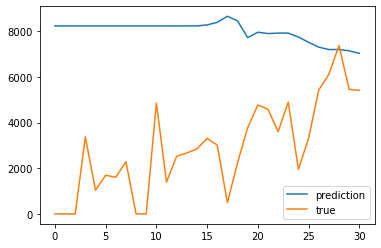

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

country = 'France'
pred = prediction[prediction["CountryName"] == country]["PredictedDailyNewCases"].values
true = df[df["CountryName"] == country]["NewCases"].values

plt.plot(pred, label="prediction")
plt.plot(true, label="true")
plt.legend();